<a href="https://colab.research.google.com/github/JHWannabe/Self_Directed_Project/blob/main/week3/Color_image_GAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data GAN-Colorization
!unzip -q Victorian400-GAN-colorization-data.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 36 (delta 12), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (36/36), done.
Downloading...
From: https://drive.google.com/uc?id=1tPNnwPISjPaC1nDZ1QpXcJAQCFmeO3Uv
To: /content/Victorian400-GAN-colorization-data.zip
100% 508M/508M [00:13<00:00, 38.1MB/s]
Victorian400-GAN-colorization-data.zip download complete!


In [ ]:
import os
import glob
import numpy as np
import datetime
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torch.autograd import Variable

In [ ]:
class VictorianDataset(Dataset):
    def __init__(self, root, color_transforms_=None, gray_transforms_=None):

        self.color_transforms = transforms.Compose(color_transforms_)
        self.gray_transforms = transforms.Compose(gray_transforms_)
        self.gray_files = sorted(glob.glob(os.path.join(root, 'gray') + "/*.*"))
        self.color_files = sorted(glob.glob(os.path.join(root, 'resized') + "/*.*"))
     
    def __getitem__(self, index):
        gray_img = Image.open(self.gray_files[index % len(self.gray_files)]).convert("RGB")
        color_img = Image.open(self.color_files[index % len(self.color_files)]).convert("RGB")
    
        gray_img = self.gray_transforms(gray_img)
        color_img = self.color_transforms(color_img)

        return {"A": gray_img, "B": color_img}

    def __len__(self):
        return len(self.gray_files)

In [ ]:
root = ''

batch_size = 12
img_height = 256
img_width = 256

In [ ]:
color_mean = [0.58090717, 0.52688643, 0.45678478]
color_std = [0.25644188, 0.25482641, 0.24456465]
gray_mean = [0.5350533, 0.5350533, 0.5350533]
gray_std = [0.25051587, 0.25051587, 0.25051587]

color_transforms_ = [
    transforms.ToTensor(),
    transforms.Normalize(mean=color_mean, std=color_std),
]

gray_transforms_ = [
    transforms.ToTensor(),
    transforms.Normalize(mean=gray_mean, std=gray_std),
]

In [ ]:
train_loader  = DataLoader(
    VictorianDataset(root, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
def reNormalize(img, mean, std):
    img = img.numpy().transpose(1, 2, 0)
    img = img * std + mean
    img = img.clip(0, 1)
    return img

torch.Size([12, 3, 256, 256]) torch.Size([12, 3, 256, 256])


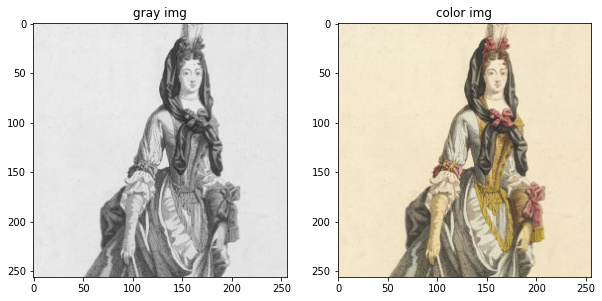

In [ ]:
fig = plt.figure(figsize=(10, 5))
rows = 1 
cols = 2

for X in train_loader :

    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(X["A"][0], gray_mean, gray_std)) 
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(X["B"][0], color_mean, color_std))
    ax2.set_title('color img')    

    plt.show()
    break

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# U-NET 생성

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [ ]:
GeneratorUNet().apply(weights_init_normal)

GeneratorUNet(
  (down1): UNetDown(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (down2): UNetDown(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down3): UNetDown(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down4): UNetDown(
    (model): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=Fals

In [ ]:
Discriminator().apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [ ]:
n_epochs = 100
dataset_name = "Victorian400"
lr = 0.0002
b1 = 0.5                    # adam: decay of first order momentum of gradient
b2 = 0.999                  # adam: decay of first order momentum of gradient
decay_epoch = 100           # epoch from which to start lr decay
#n_cpu = 8                   # number of cpu threads to use during batch generation
channels = 3                # number of image channels
checkpoint_interval = 20    # interval between model checkpoints

In [ ]:
os.makedirs("images/%s/val" % dataset_name, exist_ok=True)
os.makedirs("images/%s/test" % dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % dataset_name, exist_ok=True)

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, img_height // 2 ** 4, img_width // 2 ** 4)

# Initialize generator and discriminator
generator = GeneratorUNet()
discriminator = Discriminator()

cuda = True if torch.cuda.is_available() else False

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
def sample_images(epoch, loader, mode):
    imgs = next(iter(loader))
    gray = Variable(imgs["A"].type(Tensor))
    color = Variable(imgs["B"].type(Tensor))
    output = generator(gray)    
    
    gray_img = torchvision.utils.make_grid(gray.data, nrow=6) 
    color_img = torchvision.utils.make_grid(color.data, nrow=6)  
    output_img = torchvision.utils.make_grid(output.data, nrow=6)

    rows = 3
    cols = 1

    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(gray_img.cpu(), gray_mean, gray_std)) 
    ax1.set_title('gray')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(color_img.cpu(), color_mean, color_std))
    ax2.set_title('color')  

    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(reNormalize(output_img.cpu(), color_mean, color_std))
    ax3.set_title('output')  

    plt.show()
    fig.savefig("images/%s/%s/epoch_%s.png" % (dataset_name, mode, epoch), pad_inches=0)

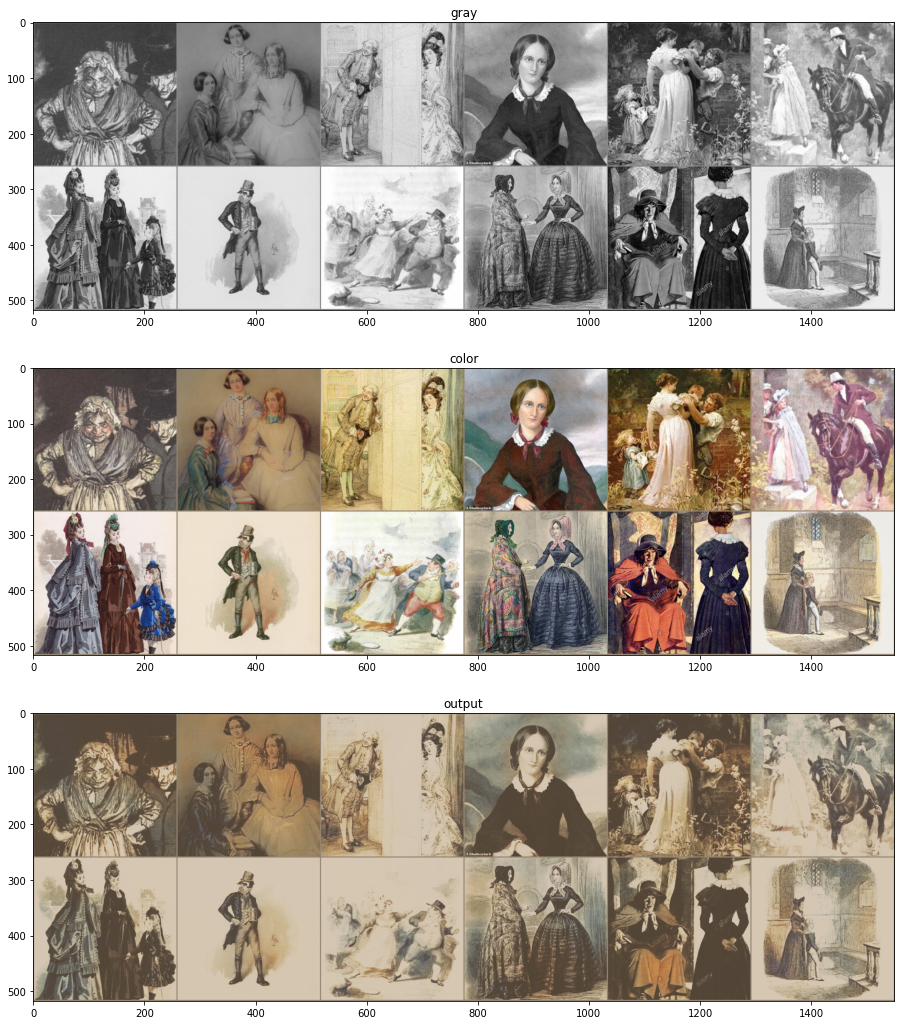

[Epoch 20/100] [Batch 34/34] [D loss: 0.003852] [G loss: 28.980534, pixel: 0.279242, adv: 1.056330] ETA: 0:00:16.281458


In [ ]:
# ----------
#  Training
# ----------

for epoch in range(1, n_epochs+1):
    start_time = datetime.datetime.now()
    for i, batch in enumerate(train_loader):

        # Model inputs
        gray = Variable(batch["A"].type(Tensor))
        color = Variable(batch["B"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((gray.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((gray.size(0), *patch))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        output = generator(gray)
        pred_fake = discriminator(output, gray)
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(output, color)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(color, gray)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(output.detach(), gray)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        epoch_time = datetime.datetime.now() - start_time

    if (epoch) % checkpoint_interval == 0:
        fig = plt.figure(figsize=(18, 18))
        sample_images(epoch, train_loader, 'val')

        torch.save(generator.state_dict(), "saved_models/%s/generator_%d.pth" % (dataset_name, epoch))
        torch.save(discriminator.state_dict(), "saved_models/%s/discriminator_%d.pth" % (dataset_name, epoch))

        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s" % (epoch, 
                                                                                                    n_epochs, 
                                                                                                    i+1, 
                                                                                                    len(train_loader), 
                                                                                                    loss_D.item(), 
                                                                                                    loss_G.item(), 
                                                                                                    loss_pixel.item(), 
                                                                                                    loss_GAN.item(), 
                                                                                                    epoch_time))
     

In [ ]:
test_root = root + 'test/'
test_batch_size = 6

test_loader = DataLoader(
    VictorianDataset(test_root, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=test_batch_size,
    shuffle=False
)

In [ ]:
fig = plt.figure(figsize=(10, 5))
rows = 1 
cols = 2

for X in test_loader:

    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(X["A"][0], gray_mean, gray_std)) 
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(X["B"][0], color_mean, color_std))
    ax2.set_title('color img')    

    plt.show()
    break

In [ ]:
generator.load_state_dict(torch.load("saved_models/%s/generator_%d.pth" % (dataset_name, n_epochs)))
discriminator.load_state_dict(torch.load("saved_models/%s/discriminator_%d.pth" % (dataset_name, n_epochs)))

In [ ]:
generator.eval()
discriminator.eval()

fig = plt.figure(figsize=(18,10))
sample_images(n_epochs, test_loader, 'test')